#Sentiment Analysis using Word embedding and BiLSTM


#Exploratory Data Analysis

### Adding libraries

In [ ]:
#pip install numpy==1.19.5

In [ ]:
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow

#from tensorflow import keras
#gensim model for word2Vec
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#model creation
from keras import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('punkt');
nltk.download('stopwords');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive

drive.mount('/content/gDrive/', force_remount=True)

Mounted at /content/gDrive/


In [ ]:
DS1=pd.read_csv('/content/gDrive/My Drive/Colab/Dissertation/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)

In [ ]:
DS1.head()

0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [ ]:
DS1=DS1[[5,0]]
DS1.columns=['tweets','sentiment']
DS1.head()

tweets  sentiment
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0
1  is upset that he can't update his Facebook by ...          0
2  @Kenichan I dived many times for the ball. Man...          0
3    my whole body feels itchy and like its on fire           0
4  @nationwideclass no, it's not behaving at all....          0

## Pre processing dataset

In [ ]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('/content/gDrive/My Drive/Colab/Dissertation/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [ ]:
%%time
DS1['processed_text'] = DS1.tweets.apply(preprocess_apply)

CPU times: user 1min 30s, sys: 404 ms, total: 1min 30s
Wall time: 1min 30s


In [ ]:
count=0
for row in DS1.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break


Text: 0
Processed: <user> <url>   aww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>
Text: 0
Processed: is upset that he cannot update his facebook by texting it   and might cry as a result  school today also  blah 
Text: 0
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: 0
Processed: my whole body feels itchy and like its on fire 
Text: 0
Processed: <user> no  it is not behaving at all  i am mad  why am i here  because i cannot see you all over there  
Text: 0
Processed: <user> not the whole crew 
Text: 0
Processed: need a hug 
Text: 0
Processed: <user> hey  long time no see  yes   rains a bit  only a bit  lol   i am fine thanks   how is you  
Text: 0
Processed: <user> nope they did not have it 
Text: 0
Processed: <user> que me muera   
Text: 0
Processed: spring break in plain city   it is snowing 


In [ ]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  
0  <user> <url>   aww  thatis a bummer   you shou...  
1  is upset that he cannot update his facebook by...  
2  <user> i dived many times for the ball  manage...  
3    my whole body feels itchy and like its on fire   
4  <user> no  it is not behaving at all  i am mad...

Remove stopwords from pre processed text

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [ ]:
DS1['tweet_without_stopwords'] = DS1['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0  <user> <url> aww thatis bummer shoulda got dav...  
1  upset cannot update facebook texting might cry...  
2  <user> dived many times ball managed save 50 r...  
3                   whole body feels itchy like fire  
4                     <user> behaving mad cannot see

In [ ]:
df2 = DS1.copy()

In [ ]:
df2.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0  <user> <url> aww thatis bummer shoulda got dav...  
1  upset cannot update facebook texting might cry...  
2  <user> dived many times ball managed save 50 r...  
3                   whole body feels itchy like fire  
4                     <user> behaving mad cannot see

In [ ]:
#dropping duplicates
df2 = df2.drop_duplicates()

In [ ]:
df2.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0  <user> <url> aww thatis bummer shoulda got dav...  
1  upset cannot update facebook texting might cry...  
2  <user> dived many times ball managed save 50 r...  
3                   whole body feels itchy like fire  
4                     <user> behaving mad cannot see

In [ ]:
df2["tweet_without_stopwords"] = df2["tweet_without_stopwords"].str.replace("<user>","")

In [ ]:
df2["processed_text"] = df2["processed_text"].str.replace("<user>","")

In [ ]:
df2.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0   <url>   aww  thatis a bummer   you shoulda go...   
1  is upset that he cannot update his facebook by...   
2   i dived many times for the ball  managed to s...   
3    my whole body feels itchy and like its on fire    
4   no  it is not behaving at all  i am mad  why ...   

                             tweet_without_stopwords  
0   <url> aww thatis bummer shoulda got david car...  
1  upset cannot update facebook texting might cry...  
2   dived many times ball managed save 50 rest go...  
3                   whole body feels itchy like fire  
4                            behaving mad cannot see

In [ ]:
df2['processed_text'].value_counts(dropna=False)

                                                                                                                                 2395
 get 100 followers a day using <url> once you add everyone you are on the train or pay vip                                       1447
 thanks                                                                                                                          1034
 thank you                                                                                                                        626
 thanks                                                                                                                           564
                                                                                                                                 ... 
awhh   no soccer for a while    blech   this sucks    but i had an amazing day                                                      1
 unfortunately  it would either have to be one of my contribut

##Basic wordcloud

In [ ]:
processedtext = list(df2['tweet_without_stopwords'])
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

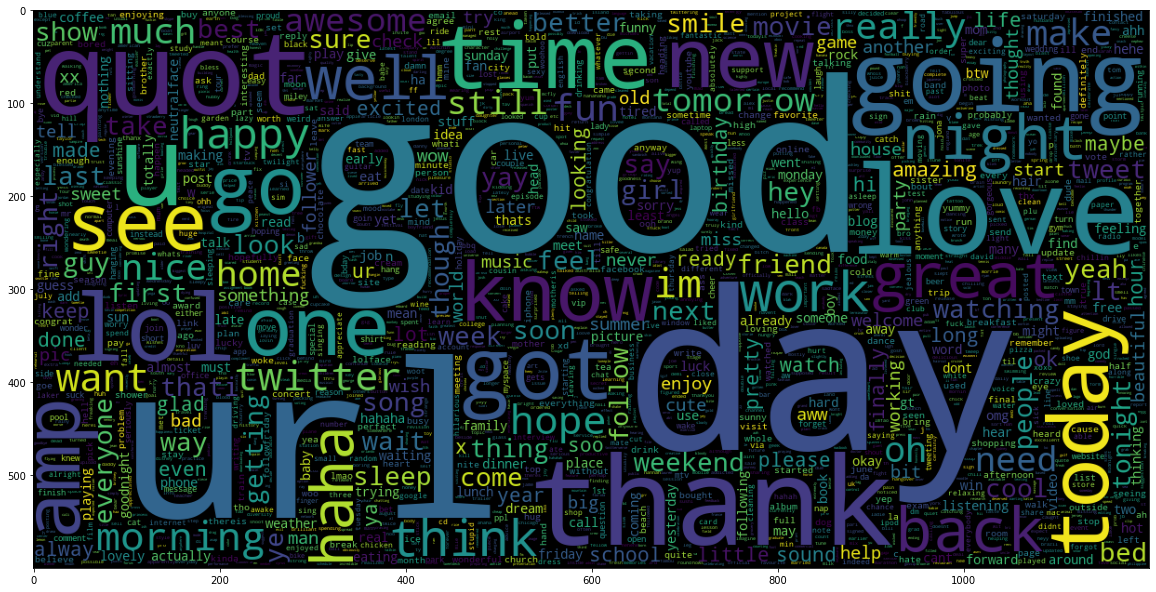

In [ ]:
#wordcloud for positive tweets
wc = WordCloud(max_words = 100000 , width = 1200 , height = 600, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

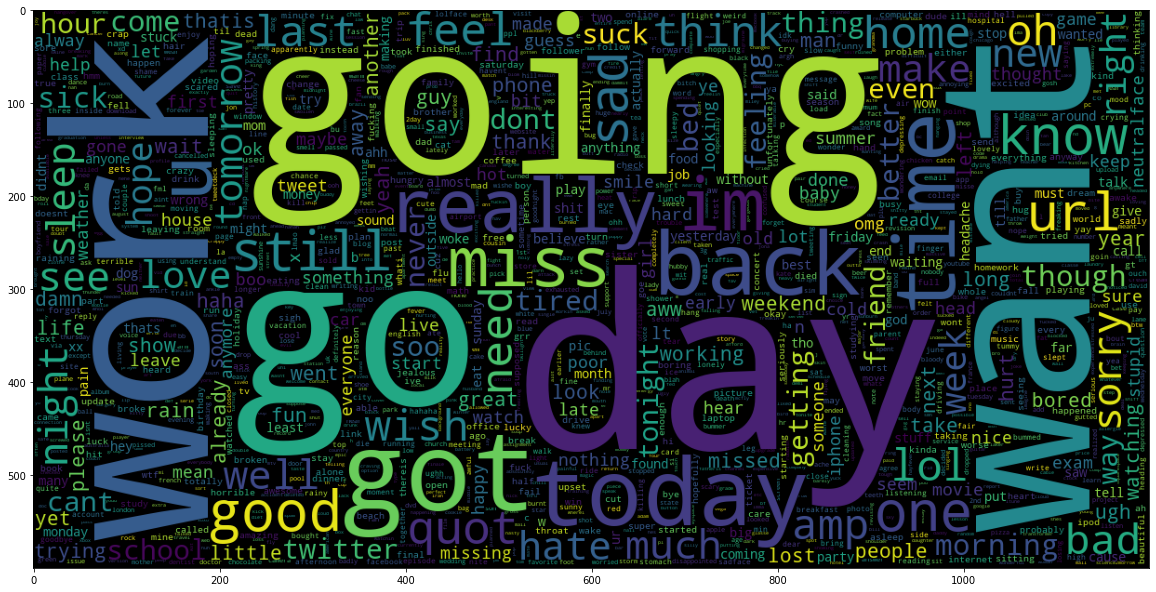

In [ ]:
#wordcloud for negative tweets
wc = WordCloud(max_words = 100000 , width = 1200 , height = 600, collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

##Splitting data for analysis

In [ ]:
#splitting data
from sklearn.model_selection import train_test_split

In [ ]:
#taking the ratio 90:10
X_data, y_data = np.array(DS1['tweet_without_stopwords']), np.array(DS1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.1, random_state = 0)
print('Data Split is done.')

Data Split is done.


In [ ]:
#!pip3 install --upgrade gensim --user
#we ran it once and restarted the timeline, so we are not going to do it again and again. once done, we will comment it.

## Checking Polarity of Tweets for dataset 1



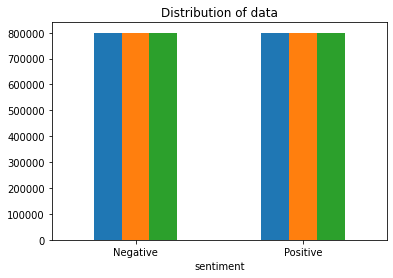

In [ ]:
ax = DS1.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

##Using word2vec for model

In [ ]:
#using gensim model

Embedding_dimensions = 1000

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 50220
CPU times: user 6min 11s, sys: 863 ms, total: 6min 12s
Wall time: 51.6 s


In [ ]:
#tokeizing and padding datasets
# Defining the model input length. using tensorflow
input_length = 60

In [ ]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


##Training the model

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1440000, 60)
X_test.shape : (160000, 60)


##Create embedding matrix

In [ ]:
#create embed matrix
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 1000)


## Creating the Sentiment model

In [ ]:
#placed in library section 

In [ ]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [ ]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 1000)          60000000  
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          880800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                   

In [ ]:
#model training
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
#compile the model
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=5,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/5
1266/1266 [==============================] - 2083s 2s/step - loss: -2002040.8750 - accuracy: 0.0230 - val_loss: -8492065.0000 - val_accuracy: 0.1014 - lr: 0.0010
Epoch 2/5
1266/1266 [==============================] - 2001s 2s/step - loss: -32930614.0000 - accuracy: 0.0458 - val_loss: -66818364.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/5
1266/1266 [==============================] - 1928s 2s/step - loss: -126587096.0000 - accuracy: 6.9676e-04 - val_loss: -199172336.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/5
1266/1266 [==============================] - 1910s 2s/step - loss: -299628448.0000 - accuracy: 0.0000e+00 - val_loss: -414889472.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/5
1266/1266 [==============================] - 1881s 1s/step - loss: -561778432.0000 - accuracy: 0.0000e+00 - val_loss: -722388736.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010


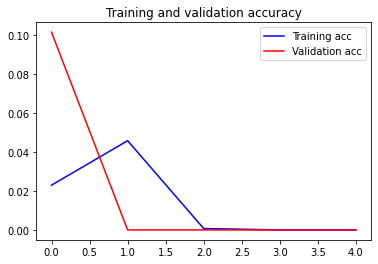

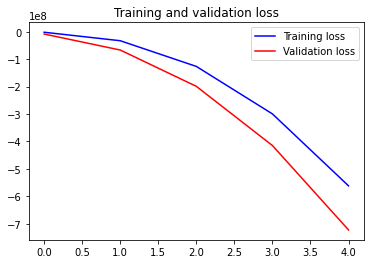

In [ ]:
#evaluate the model
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## creating Confusion matrix for sentiment analysis

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Predicting model trained based on dataset

In [ ]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 0, 1)
#y_pred.where(y_pred >= 0.5,1,0)

# Printing out the Evaluation metrics. 
#ConfusionMatrix(y_pred, y_test)

In [ ]:
#from sklearn.svm import SVC
#clf = SVC(random_state=0)
#clf.fit(X_train, y_train)

In [ ]:
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(clf,y_pred, y_test) 

In [ ]:
#plt.show()

In [ ]:
#classification report
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     79738
           4       0.00      0.00      0.00     80262

    accuracy                           0.50    160000
   macro avg       0.25      0.50      0.33    160000
weighted avg       0.25      0.50      0.33    160000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Saving the model

In [ ]:
#save the model
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-BiLSTM')
training_model.save_weights("Model Weights/weights")

#Sentiment Analysis using ML algorithms (Bernoulli NB, Multinomial NB, Logistic regression)
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

It contains the following 6 fields:

target: the polarity of the tweet (0 = negative, 4 = positive) ids: The id of the tweet ( 2087) date: the date of the tweet (Sat May 16 23:58:44 UTC 2009) flag: The query (lyx). If there is no query, then this value is NO_QUERY. user: the user that tweeted (robotickilldozr) text: the text of the tweet (Lyx is cool)

In the Jupyter Notebook, we perform exploratory anaylysis of tweets, with WordClouds, preprocess the tweets, perform count vectorization and run several classification models and evaluate them.

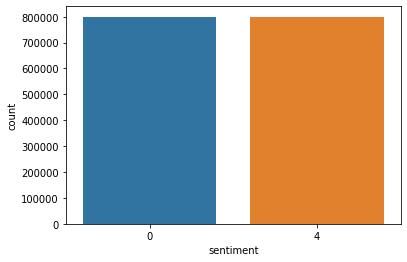

In [ ]:
import seaborn as sns
sns.countplot(x="sentiment", data=DS1)

In [ ]:
DS1.tail()

tweets  sentiment  \
1599995  Just woke up. Having no school is the best fee...          4   
1599996  TheWDB.com - Very cool to hear old Walt interv...          4   
1599997  Are you ready for your MoJo Makeover? Ask me f...          4   
1599998  Happy 38th Birthday to my boo of alll time!!! ...          4   
1599999  happy #charitytuesday @theNSPCC @SparksCharity...          4   

                                            processed_text  \
1599995  just woke up  having no school is the best fee...   
1599996  thewdb com   very cool to hear old walt interv...   
1599997  are you ready for your mojo makeover  ask me f...   
1599998  happy 38th birthday to my boo of all time   tu...   
1599999        happy  charitytuesday <user> <user> <user>    

                                 tweet_without_stopwords  
1599995                    woke school best feeling ever  
1599996   thewdb com cool hear old walt interviews <url>  
1599997                  ready mojo makeover ask details  
1599998  happy 38th birthday boo time tupac amaru shakur  
1599999        happy charitytuesday <user> <user> <user>

In [ ]:
DS1[['tweets','sentiment']].sample(10)

tweets  sentiment
1417593  @ijustine I like the pre because its less tren...          4
1595983  Relaxing morning on the golf course, then lunc...          4
746602   @riptide1922: I knoww  let's plan for this or ...          0
229381     cool party but not enough people will dance...           0
577313   @mcangeli yea, it made it grey   was a good id...          0
622180                                 my printer is evil           0
420041   @lochnesrockstar I HAD NIGHTMARES TOO. SCREW Y...          0
870779   @Celticpussycat I wanna drag someone through t...          4
1060928  @Jennifalconer Hollies' from Accrington, where...          4
736592   Doesn't wanna go to work and leave her baby at...          0

In [ ]:
DS1 = DS1[['tweets','sentiment']]
DS1.describe()

sentiment
count  1.600000e+06
mean   2.000000e+00
std    2.000001e+00
min    0.000000e+00
25%    0.000000e+00
50%    2.000000e+00
75%    4.000000e+00
max    4.000000e+00

In [ ]:
DS1['length'] = DS1['tweets'].apply(len)

In [ ]:
DS1[DS1['length'] == 74]['tweets'].iloc[0]

"My thoughts are with Sandra Cantu's family at this difficult and sad time "

In [ ]:
DS1[DS1['length'] == 6]['tweets'].iloc[0]

' just '

In [ ]:
DS1[DS1['length'] == 70]['tweets'].iloc[0]

"Today I realized I am too good at hiding things, even I can't find it "

In [ ]:
DS1["tweet_without_stopwords"] = DS1["tweet_without_stopwords"].str.replace("<user>","")

In [ ]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0   <url> aww thatis bummer shoulda got david car...  
1  upset cannot update facebook texting might cry...  
2   dived many times ball managed save 50 rest go...  
3                   whole body feels itchy like fire  
4                            behaving mad cannot see

In [ ]:
sentences = DS1['tweet_without_stopwords'].tolist()
sentences_string = " ".join(sentences)

### Word cloud visualization

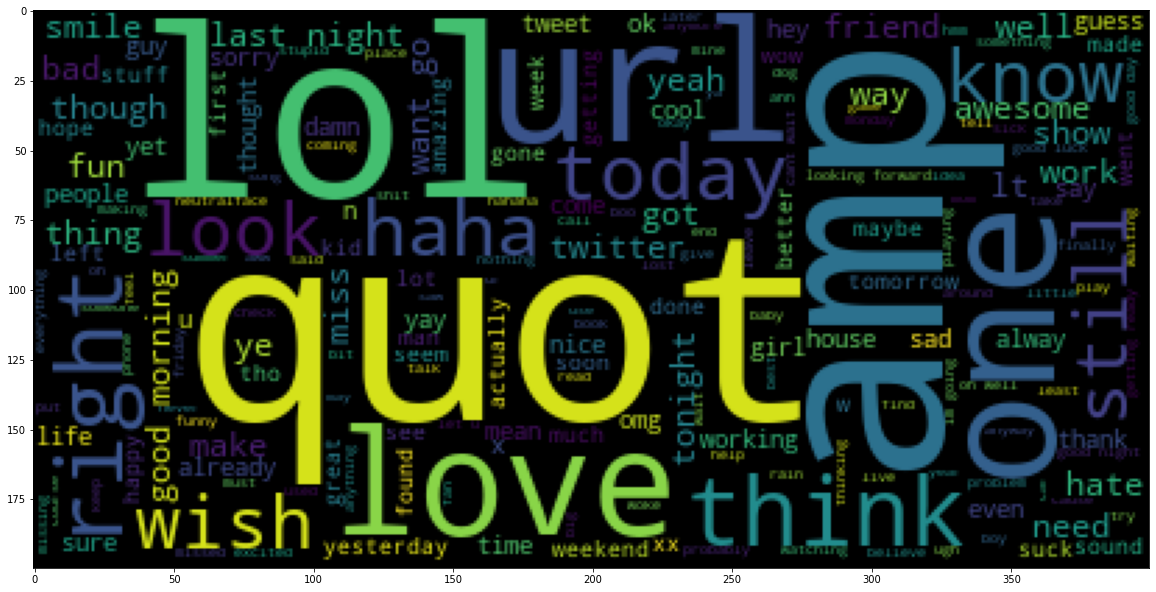

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_string))

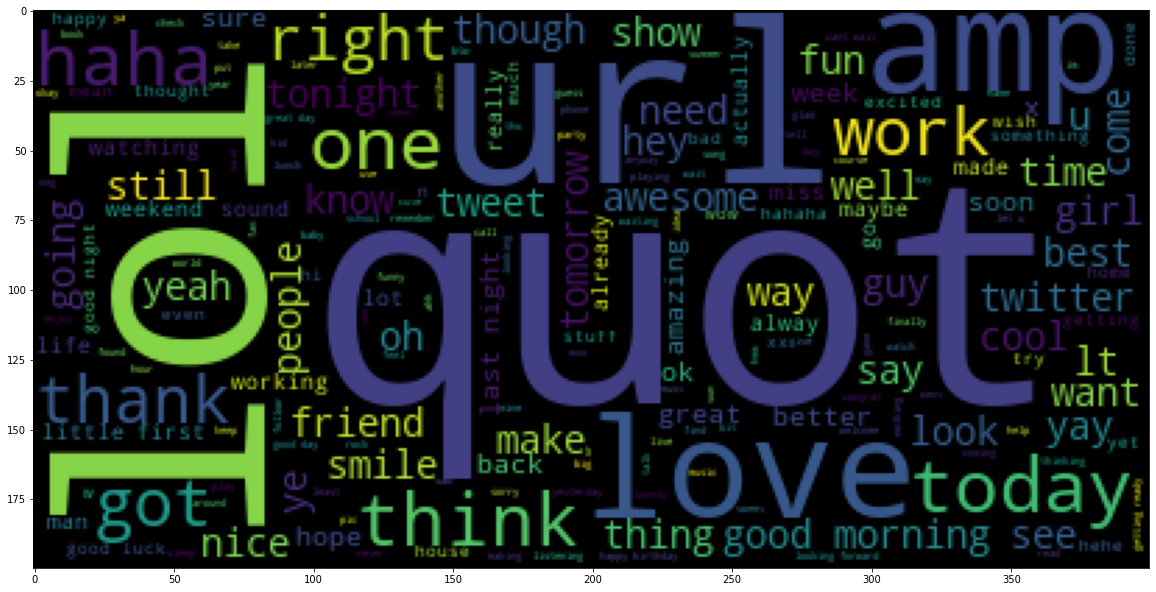

In [ ]:
#positive tweets
sentences = DS1[DS1['sentiment'] == 4]['tweet_without_stopwords'].tolist()
sentences_string = " ".join(sentences)

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_string))

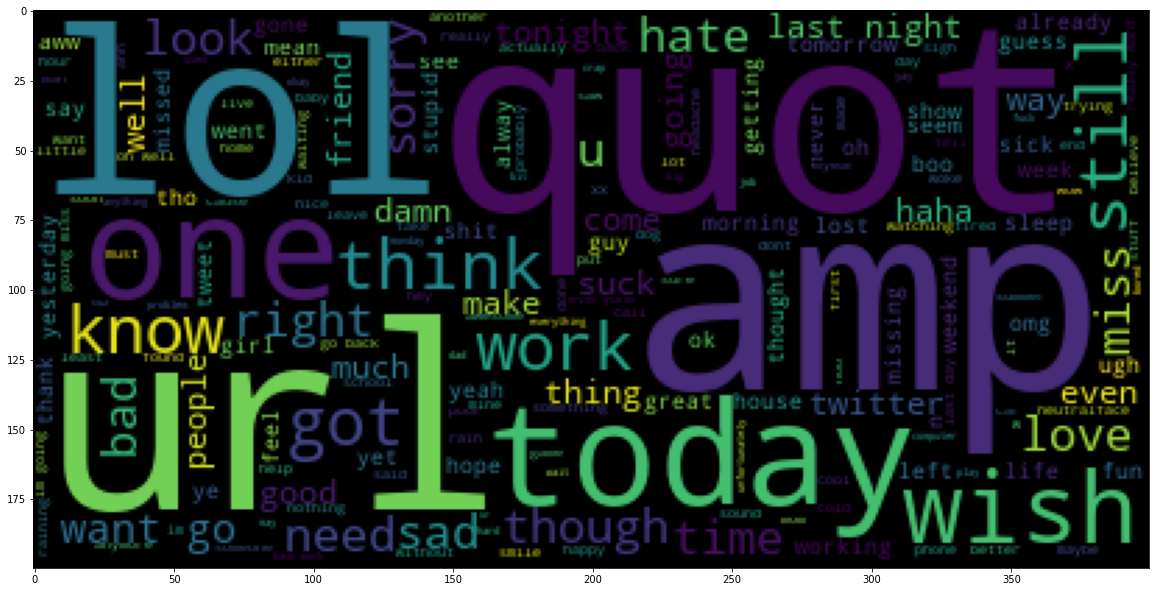

In [ ]:
#negative tweets
sentences = DS1[DS1['sentiment'] == 0]['tweet_without_stopwords'].tolist()
sentences_string = " ".join(sentences)

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_string))

### ML algorithms used

In [ ]:
import string
string.punctuation
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
def message_cleaning(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

In [ ]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0   <url> aww thatis bummer shoulda got david car...  
1  upset cannot update facebook texting might cry...  
2   dived many times ball managed save 50 rest go...  
3                   whole body feels itchy like fire  
4                            behaving mad cannot see

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = message_cleaning, dtype = 'uint8')
DS1_countvectorizer = vectorizer.fit_transform(DS1['tweet_without_stopwords'])

In [ ]:
DS1_countvectorizer.shape

(1600000, 272177)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DS1_countvectorizer, DS1['sentiment'],test_size = 0.25, random_state = 0)

In [ ]:
X_train.shape

(1200000, 272177)

In [ ]:
X_test.shape

(400000, 272177)

In [ ]:
y_train.shape

(1200000,)

In [ ]:
y_test.shape

(400000,)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

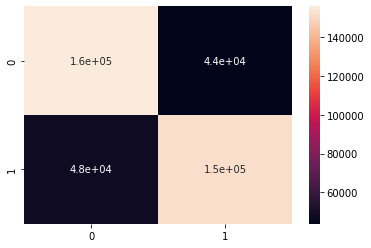

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77    199734
           4       0.78      0.76      0.77    200266

    accuracy                           0.77    400000
   macro avg       0.77      0.77      0.77    400000
weighted avg       0.77      0.77      0.77    400000



In [ ]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)

BernoulliNB(alpha=2)

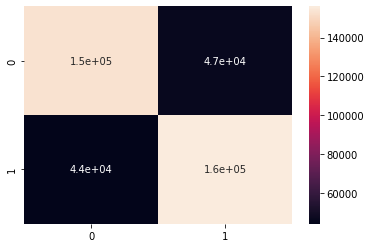

In [ ]:
y_predict_test = BNBmodel.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77    199734
           4       0.77      0.78      0.77    200266

    accuracy                           0.77    400000
   macro avg       0.77      0.77      0.77    400000
weighted avg       0.77      0.77      0.77    400000



In [ ]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C =2, max_iter=1000, n_jobs=1)
LRmodel.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=2, n_jobs=1)

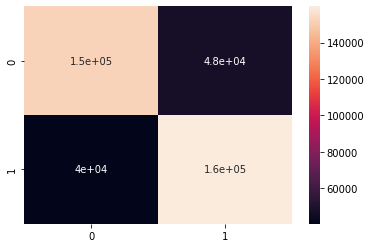

In [ ]:
y_predict_test = LRmodel.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78    199734
           4       0.77      0.80      0.78    200266

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.78      0.78      0.78    400000



#Most common words used

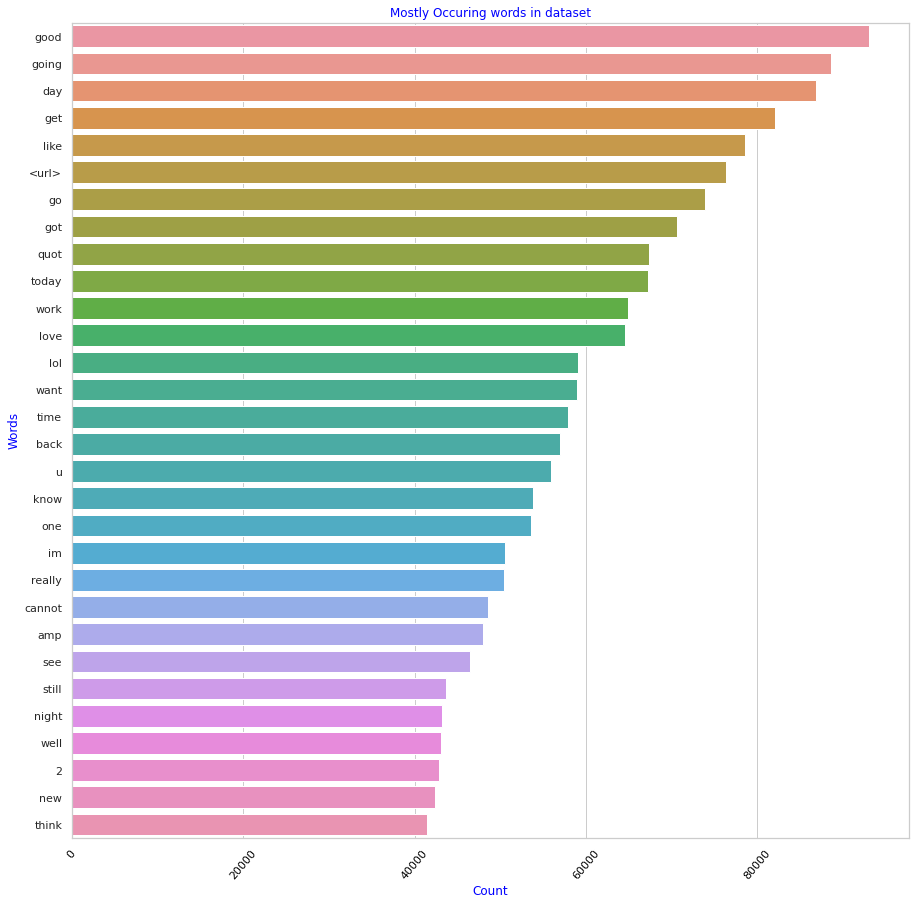

In [ ]:
from collections import Counter #import Counter for finding most common words
import seaborn as sns #import searbon for vizualization result

text = DS1['tweet_without_stopwords']
words = text.str.split(expand=True).unstack()
result_count = Counter(words).most_common()
result_df = pd.DataFrame(result_count).reset_index().drop(0) #converting to Dataframe and drop the Nones values
#result_df
#vizualize result
sns.set_theme(style="whitegrid") 
f, ax = plt.subplots(figsize=(15, 15)) 
sns.barplot(y=result_df[0][0:30], x=result_df[1][0:30], data=result_df, palette=None)
plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
plt.title("Mostly Occuring words in dataset", color="blue") 
plt.xticks(rotation=50);
ax.tick_params(axis='x', colors='black')
plt.show()


#Considering negative words as sarcastic and finding out the most occuring words

In [ ]:
#create DataFrame for non_sarcastic words 
non_sarcastic = pd.DataFrame(DS1[DS1['sentiment']==0]['tweet_without_stopwords'].str.split(expand=True).unstack().value_counts()).reset_index()

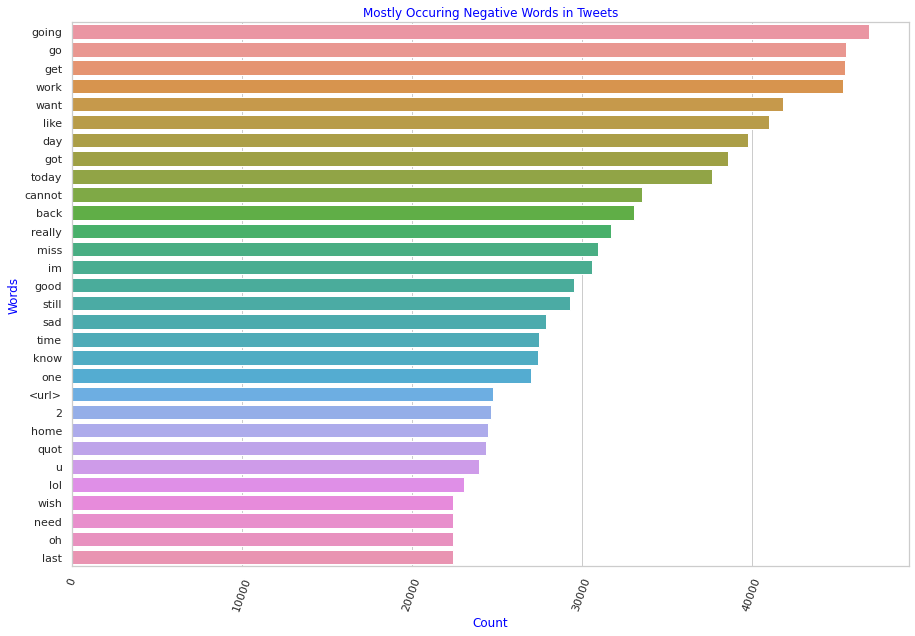

In [ ]:
#vizualize result
sns.set_theme(style="whitegrid") 
f, ax = plt.subplots(figsize=(15, 10)) 
sns.barplot(y=non_sarcastic['index'][0:30], x=non_sarcastic[0][0:30], data=result_df, palette=None)
plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
plt.title("Mostly Occuring Sarcastic Words in Tweets", color="blue") 
plt.xticks(rotation=70);
plt.show()


#Considering positive words as non -sarcastic and finding out the most occuring words

In [ ]:
sarcastic = pd.DataFrame(DS1[DS1['sentiment']==4]['tweet_without_stopwords'].str.split(expand=True).unstack().value_counts()).reset_index()

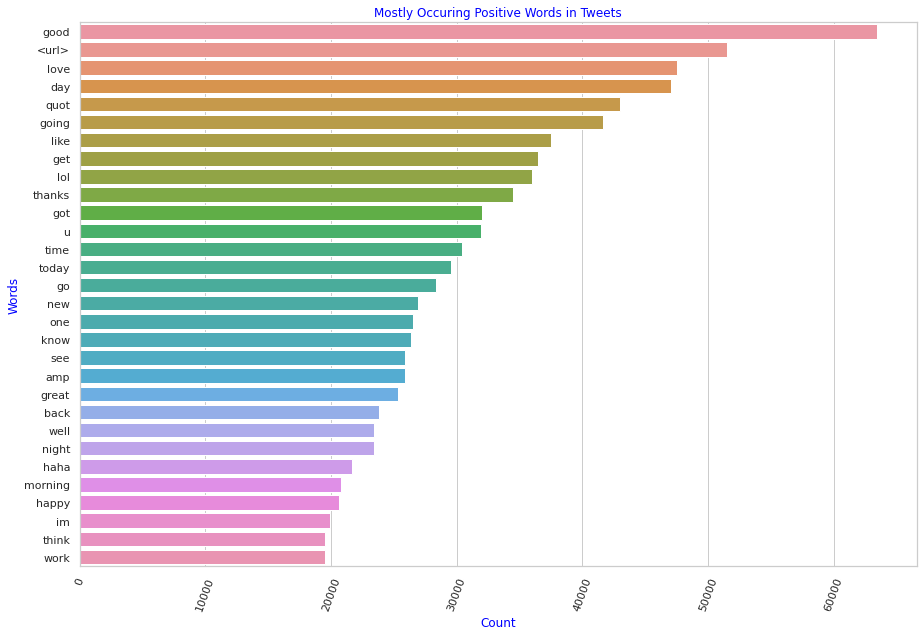

In [ ]:
#vizualize result
sns.set_theme(style="whitegrid") 
f, ax = plt.subplots(figsize=(15, 10)) 
sns.barplot(y=sarcastic['index'][0:30], x=sarcastic[0][0:30], data=result_df, palette=None)
plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
plt.title("Mostly Occuring Non Sarcastic Words in Tweets", color="blue") 
plt.xticks(rotation=70);
plt.show()

#Sarcasm detection with CNN, LSTM, Bi LSTM, Bi GRU

In [ ]:
#Using Preprocessed data
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0  <user> <url> aww thatis bummer shoulda got dav...  
1  upset cannot update facebook texting might cry...  
2  <user> dived many times ball managed save 50 r...  
3                   whole body feels itchy like fire  
4                     <user> behaving mad cannot see

In [ ]:
DS1["tweet_without_stopwords"] = DS1["tweet_without_stopwords"].str.replace("<user>","")

In [ ]:
DS1.head()

tweets  sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0   
1  is upset that he can't update his Facebook by ...          0   
2  @Kenichan I dived many times for the ball. Man...          0   
3    my whole body feels itchy and like its on fire           0   
4  @nationwideclass no, it's not behaving at all....          0   

                                      processed_text  \
0  <user> <url>   aww  thatis a bummer   you shou...   
1  is upset that he cannot update his facebook by...   
2  <user> i dived many times for the ball  manage...   
3    my whole body feels itchy and like its on fire    
4  <user> no  it is not behaving at all  i am mad...   

                             tweet_without_stopwords  
0   <url> aww thatis bummer shoulda got david car...  
1  upset cannot update facebook texting might cry...  
2   dived many times ball managed save 50 rest go...  
3                   whole body feels itchy like fire  
4                            behaving mad cannot see

In [ ]:
#shuffle data to split into train, test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DS1['tweet_without_stopwords'], DS1['sentiment'], train_size = 0.7, random_state = 42, shuffle = True)

In [ ]:
DS1.shape
train_dataframe = DS1[0:80000]
test_dataframe = DS1[80000:]

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1120000
1120000
480000
480000


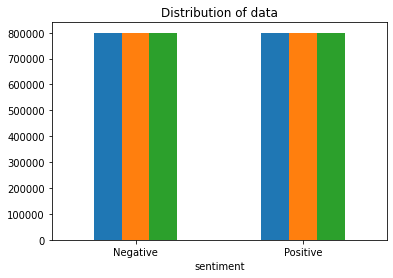

In [ ]:
ax = DS1.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [ ]:
#tokenize text
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
embedding_dim = 16
max_length = 100
training_size = 80000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
history = model.fit(training_padded, training_labels, epochs=5, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/5
35000/35000 - 104s - loss: 4.9988 - mean_squared_error: 4.9988 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 104s/epoch - 3ms/step
Epoch 2/5
35000/35000 - 97s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 97s/epoch - 3ms/step
Epoch 3/5
35000/35000 - 93s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 93s/epoch - 3ms/step
Epoch 4/5
35000/35000 - 101s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 101s/epoch - 3ms/step
Epoch 5/5
35000/35000 - 95s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 95s/epoch - 3ms/step


##CNN model

In [ ]:
#CNN Model
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
history1 = model1.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
35000/35000 - 228s - loss: 4.9964 - mean_squared_error: 4.9964 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 228s/epoch - 7ms/step
Epoch 2/10
35000/35000 - 212s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 212s/epoch - 6ms/step
Epoch 3/10
35000/35000 - 218s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 218s/epoch - 6ms/step
Epoch 4/10
35000/35000 - 225s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 225s/epoch - 6ms/step
Epoch 5/10
35000/35000 - 225s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 225s/epoch - 6ms/step
Epoch 6/10
35000/35000 - 255s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 255s/epoch - 7ms/step
Epoch 7/10
35000/35000 - 302s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_m

## LSTM model

In [ ]:
#LSTM model
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
history2 = model2.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
35000/35000 - 1936s - loss: 4.9963 - mean_squared_error: 4.9963 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 1936s/epoch - 55ms/step
Epoch 2/10
35000/35000 - 1646s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 1646s/epoch - 47ms/step
Epoch 3/10
35000/35000 - 1615s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 1615s/epoch - 46ms/step
Epoch 4/10
35000/35000 - 1501s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 1501s/epoch - 43ms/step
Epoch 5/10
35000/35000 - 1469s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 1469s/epoch - 42ms/step
Epoch 6/10
35000/35000 - 1470s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 1470s/epoch - 42ms/step
Epoch 7/10
35000/35000 - 1519s - loss: 4.9954 - mean_squared_error: 4.9954 - val_l

##Bi lstm

In [ ]:
#Building the LSTM Model
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 164,429
Trainable params: 164,429
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
history3=model3.fit(training_padded, training_labels, batch_size=1000,epochs=10, verbose=2, validation_data=(testing_padded, testing_labels))

Epoch 1/10
1120/1120 - 328s - loss: 5.0444 - mean_squared_error: 5.0444 - val_loss: 5.0110 - val_mean_squared_error: 5.0110 - 328s/epoch - 292ms/step
Epoch 2/10
1120/1120 - 268s - loss: 4.9956 - mean_squared_error: 4.9956 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 268s/epoch - 239ms/step
Epoch 3/10
1120/1120 - 285s - loss: 4.9955 - mean_squared_error: 4.9955 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 285s/epoch - 255ms/step
Epoch 4/10
1120/1120 - 332s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 332s/epoch - 297ms/step
Epoch 5/10
1120/1120 - 337s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 337s/epoch - 301ms/step
Epoch 6/10
1120/1120 - 321s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mean_squared_error: 5.0107 - 321s/epoch - 286ms/step
Epoch 7/10
1120/1120 - 343s - loss: 4.9954 - mean_squared_error: 4.9954 - val_loss: 5.0107 - val_mea

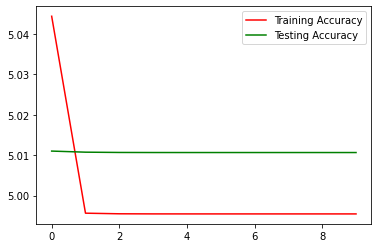

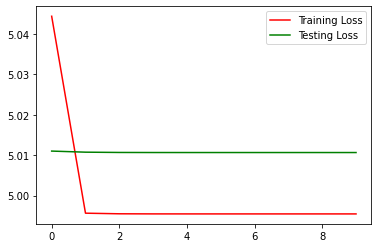

In [ ]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
mse=history3.history['mean_squared_error']
val_mse=history3.history['val_mean_squared_error']
loss=history3.history['loss']
val_loss=history3.history['val_loss']

epochs=range(len(mse)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,mse,'r',label='Training Accuracy')
plt.plot(epochs,val_mse,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()

##Bidirectional GATED RECURRENT UNIT (GRU)

In [ ]:
#Building the GRU Model
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model4.summary() 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               3264      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 6)                 198       
                                                                 
 dense_13 (Dense)            (None, 1)                 7         
                                                                 
Total params: 163,469
Trainable params: 163,469
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
history4=model4.fit(training_padded, training_labels, batch_size=1000,epochs=10, verbose=2, validation_data=(testing_padded, testing_labels))

Epoch 1/10
1120/1120 - 196s - loss: 5.8833 - mean_squared_error: 5.8833 - val_loss: 5.6117 - val_mean_squared_error: 5.6117 - 196s/epoch - 175ms/step
Epoch 2/10
1120/1120 - 191s - loss: 5.3846 - mean_squared_error: 5.3846 - val_loss: 5.2345 - val_mean_squared_error: 5.2345 - 191s/epoch - 170ms/step
Epoch 3/10
1120/1120 - 191s - loss: 5.1214 - mean_squared_error: 5.1214 - val_loss: 5.0765 - val_mean_squared_error: 5.0765 - 191s/epoch - 170ms/step
Epoch 4/10
1120/1120 - 191s - loss: 5.0019 - mean_squared_error: 5.0019 - val_loss: 5.0005 - val_mean_squared_error: 5.0005 - 191s/epoch - 170ms/step
Epoch 5/10
1120/1120 - 190s - loss: 4.9373 - mean_squared_error: 4.9373 - val_loss: 4.9646 - val_mean_squared_error: 4.9646 - 190s/epoch - 170ms/step
Epoch 6/10
1120/1120 - 190s - loss: 4.8988 - mean_squared_error: 4.8988 - val_loss: 4.9403 - val_mean_squared_error: 4.9403 - 190s/epoch - 169ms/step
Epoch 7/10
1120/1120 - 190s - loss: 4.8745 - mean_squared_error: 4.8745 - val_loss: 4.9294 - val_mea

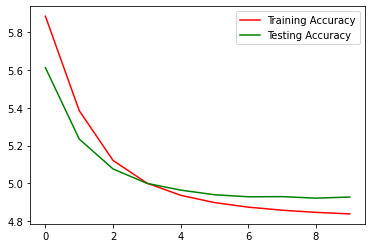

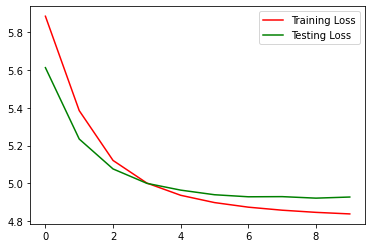

In [ ]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
mse=history4.history['mean_squared_error']
val_mse=history4.history['val_mean_squared_error']
loss=history4.history['loss']
val_loss=history4.history['val_loss']

epochs=range(len(mse)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,mse,'r',label='Training Accuracy')
plt.plot(epochs,val_mse,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()

## Graphs of CNN/LSTM/BiLSTM/BiGRU based on accuracy

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import DataFrame
mse = [max(history1.history['val_mean_squared_error']),max(history2.history['val_mean_squared_error']), max(history3.history['val_mean_squared_error']), max(history4.history['val_mean_squared_error'])]
loss = [max(history1.history['val_loss']),max(history2.history['val_loss']),max(history3.history['val_loss']), max(history4.history['val_loss'])]

col={'MSE':mean_squared_error,'Loss':loss}
models=['CNN','LSTM','Bi LSTM', 'Bi GRU']
graph_df=DataFrame(data=col,index=models)
graph_df

In [ ]:
graph_df.plot(kind='bar')